# Validation
### Checking the relevance of Feature Engineering and correlation to remove unecessary variables and improve the accuracy

The aim is to create a model to predict next headway with:
* all variables
* selected variables

In [55]:
import pandas as pd
import pandas_profiling
import numpy as np
import os
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import time

In [5]:
# Choose the city of analysis

city = 'Recife'
# city = 'CG'
# city = 'Curitiba'

In [6]:
path = os.getcwd() + "/../data/output/" + city + "/"

# All variables
all_data = "new_feats_data.csv"
integrated_data_path = path + all_data

# Selected variables
selected_data = "selected_data.csv"
selected_data_path = path + selected_data

In [30]:
# Reading data

df_all_data = pd.read_csv(integrated_data_path)

In [31]:
df_selected_data = pd.read_csv(integrated_data_path)

In [32]:
rows_number = 50000

df_all_data = df_all_data.loc[0:rows_number]
df_selected_data = df_selected_data.loc[0:rows_number]

### Converting NaN values

Changing NaN by median or:
- values of shape for gps

In [10]:
df_all_data.isnull().any()

route                               False
tripNum                             False
shapeId                             False
routeFrequency                      False
shapeSequence                       False
shapeLat                            False
shapeLon                            False
distanceTraveledShape               False
busCode                             False
gpsPointId                           True
gpsLat                               True
gpsLon                               True
distanceToShapePoint                 True
stopPointId                         False
problem                             False
alertSubtype                        False
alertType                           False
alertRoadType                        True
alertConfidence                      True
alertNComments                       True
alertNImages                         True
alertNThumbsUp                       True
alertReliability                     True
alertReportMood                   

In [33]:
# changing by shape data
df_all_data.gpsPointId = np.where(df_all_data.gpsPointId.isnull(), 0, df_all_data.gpsPointId)
df_all_data.gpsLat = np.where(df_all_data.gpsLat.isnull(), df_all_data.shapeLat, df_all_data.gpsLat)
df_all_data.gpsLon = np.where(df_all_data.gpsLon.isnull(), df_all_data.shapeLon, df_all_data.gpsLon)
df_all_data.distanceToShapePoint = np.where(df_all_data.distanceToShapePoint.isnull(), 
                                            0, df_all_data.distanceToShapePoint)


In [34]:
#grouping by weekday and filling NA's with the median of the column
numeric_feats = df_all_data.dtypes[(df_all_data.dtypes != "object") & (df_all_data.dtypes != "datetime64[ns]")
                               & (df_all_data.dtypes != "bool")].index
df_all_data[numeric_feats] = df_all_data.groupby(['WEEKDAY(gps_datetime)'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

df_all_data.head(5)

,route,tripNum,shapeId,routeFrequency,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,...,YEAR(jamUpdateDateTime),YEAR(jamExpirationDateTime),MONTH(gps_datetime),MONTH(alertDateTime),MONTH(jamUpdateDateTime),MONTH(jamExpirationDateTime),WEEKDAY(gps_datetime),WEEKDAY(alertDateTime),WEEKDAY(jamUpdateDateTime),WEEKDAY(jamExpirationDateTime)
0,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50665,0.0,...,2018.0,2019.0,12,12.0,12.0,2.0,5,5.0,5.0,3.0
1,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50673,0.0,...,2018.0,2019.0,12,12.0,12.0,2.0,5,5.0,5.0,3.0
2,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50662,0.0,...,2018.0,2019.0,12,12.0,12.0,2.0,5,5.0,5.0,3.0
3,96,2,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50673,0.0,...,2018.0,2019.0,12,12.0,12.0,2.0,5,5.0,5.0,3.0
4,96,2,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50662,176265.0,...,2018.0,2019.0,12,12.0,12.0,2.0,5,5.0,5.0,3.0


In [ ]:
df_all_data.isnull().any()

In [ ]:
df_all_data.dtypes

In [35]:
# Converting bool to float
df_all_data.alertIsJamUnifiedAlert = df_all_data.alertIsJamUnifiedAlert.astype(np.float64)
df_all_data.alertInScale = df_all_data.alertInScale.astype(np.float64)
df_all_data.busBunching = df_all_data.busBunching.astype(np.float64)

### Converting categorical variables

In [36]:
df_all_data = pd.get_dummies(df_all_data)
df_all_data.head()

,route,tripNum,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,...,alertSubtype_JAM_STAND_STILL_TRAFFIC,alertSubtype_POLICE_HIDING,alertSubtype_POLICE_VISIBLE,alertType_-,alertType_ACCIDENT,alertType_HAZARD,alertType_JAM,alertType_POLICE,jamBlockType_-,jamBlockType_ROAD_CLOSED_EVENT
0,96,1,22857,-8.046589,-34.878125,3606.0,50665,0.0,-8.046589,-34.878125,...,0,0,0,0,1,0,0,0,1,0
1,96,1,22857,-8.046589,-34.878125,3606.0,50673,0.0,-8.046589,-34.878125,...,0,0,0,0,1,0,0,0,1,0
2,96,1,22857,-8.046589,-34.878125,3606.0,50662,0.0,-8.046589,-34.878125,...,0,0,0,0,1,0,0,0,1,0
3,96,2,22857,-8.046589,-34.878125,3606.0,50673,0.0,-8.046589,-34.878125,...,0,0,0,0,1,0,0,0,1,0
4,96,2,22857,-8.046589,-34.878125,3606.0,50662,176265.0,-8.046504,-34.878170,...,0,0,0,0,1,0,0,0,1,0


In [15]:
# Descriptive statistics
profile = pandas_profiling.ProfileReport(df_all_data, check_correlation=True, correlation_threshold=0.5)

NameError: name 'pandas_profiling' is not defined

## Model with all variables

In [37]:
# y = df_all_data.drop('busBunching', axis=1) # with classifier produce error: asking to convert to float (doesn't make sense, it's a class)
y = df_all_data['headway']

df_all_data.drop('headway', axis=1, inplace=True)
headway_busBunching = df_all_data['headwayThreshold', 'busBunching']
df_all_data.drop('busBunching', axis=1, inplace=True)
 
X = df_all_data

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.5)

#### Modelo RF (Random Forest)
Random Forest é um algoritmo que ajusta várias árvores de decisão de classificação em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. A quantidade de árvores (n_estimators) é um parâmetro, cujo valor, deve ser encontrado, para que o modelo melhor represente os dados.

In [51]:
# function to train the model and to calculate the RMSE with cross validation
def rmse_cv(model, X_train, y_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

# function to print the coefficients of the model
def print_coefficients(model):
    w = list(model.coef_)
    # Parameters must be in reverse order because the poly function 
    w.reverse()
    print (np.poly1d(w) + model.intercept_)

# function to train the model and to return the score
def train_model(model, X_train, y_train, X_test, y_test, print_coef):
    start_time = time.time()

    model.fit(X_train, y_train)
#     if (print_coef):
#         print_coefficients(model)
    
    score = model.score(X_test, y_test) #how well our model is
    y_predict = model.predict(X_test)
    execution_time = time.time() - start_time
    return score, execution_time, y_predict

# function to plot the RMSE vs parameter value
def plot_rmse_param(series, param_name):
    series.plot(title = "Validation Error vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    
# function to get the best RMSE and the best parameter value of the model
def best_rmse_param(series):
    best_rmse = series.min()
    best_param = series.idxmin() 
    
    return(best_rmse, best_param)

def get_accuracy(y_predicted, y_real):
    df['predictedBusBunching'] = np.where((y_predicted >= y_real['headwayThreshold'], 'True', 'False')
                             
    df['elderly'] = np.where((y_predicted >= y_real['headwayThreshold'], 'True', 'False')
    

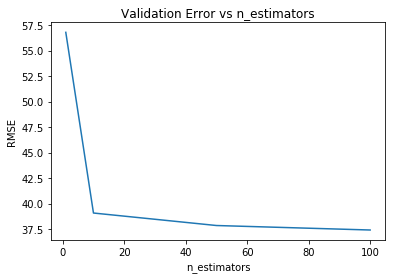

In [39]:
n_estimators = [1, 10, 50, 100]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = n), X_train_all, y_train_all).mean() 
            for n in n_estimators]

series = pd.Series(cv_rf_rmse, index = n_estimators)
plot_rmse_param(series, "n_estimators")

In [52]:
best_rmse_rf, best_param_rf = best_rmse_param(series)

model_rf = RandomForestRegressor(n_estimators = best_param_rf)
score_rf, exec_time_all, y_predict = train_model(model_rf, X_train_all, y_train_all, X_test_all, y_test_all, 
                                      False)

In [57]:
cs = [0.01, 1, 5, 10, 25, 50]
cv_svr_rmse = [rmse_cv(SVR(C = c), X_train_all, y_train_all).mean() 
            for c in cs]

series_svr = pd.Series(cv_svr_rmse, index = cs)
plot_rmse_param(series_svr, "C")

c:\python27\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


KeyboardInterrupt: 

In [ ]:
best_rmse_svr_all, best_param_svr_all = best_rmse_param(series_svr)

model_svr_all = SVR(C = best_rmse_svr_all)
score_svr_all, exec_time_svr_all = train_model(model_svr_all, False)

Rodar paralelo

Alterar para acurácia: pegar a saída e calcular com a coluna bb

Tentar justificar com acurácia (parece estabilizar), tempo de execução e explicabilidade 

Usar regressão (reduzir dimensionalidade) -> é linear (RF foi aleatório) ou outros modelos

## Model with less (13) variables

- Todas as variáveis de dia, mês e ano - data do gps é suficiente
- alertInScale - alertIsJamUnifiedAlert é suficiente
- alertLat e alertLon - localização do gps é suficiente
- alertNThumbsUp e alertReliability - alertConfidence é suficiente
- jamDelay e jamLenght - jamSeverity é suficiente

In [41]:
df_selected_data.drop(['DAY(alertDateTime)', 'DAY(jamUpdateDateTime)', 'MONTH(alertDateTime)', 
                       'MONTH(jamUpdateDateTime)', 'YEAR(alertDateTime)', 'YEAR(jamUpdateDateTime)',
                      'alertInScale', 'alertLatitude', 'alertLongitude', 'alertNThumbsUp',
                      'alertReliability', 'jamDelay', 'jamLength'], axis=1, inplace=True)

In [42]:
# changing by shape data
df_selected_data.gpsPointId = np.where(df_selected_data.gpsPointId.isnull(), 0, 
                                       df_selected_data.gpsPointId)
df_selected_data.gpsLat = np.where(df_selected_data.gpsLat.isnull(), df_selected_data.shapeLat,
                                   df_selected_data.gpsLat)
df_selected_data.gpsLon = np.where(df_selected_data.gpsLon.isnull(), df_selected_data.shapeLon, 
                                   df_selected_data.gpsLon)
df_selected_data.distanceToShapePoint = np.where(df_selected_data.distanceToShapePoint.isnull(), 
                                            0, df_selected_data.distanceToShapePoint)


In [43]:
#grouping by weekday and filling NA's with the median of the column
numeric_feats = df_selected_data.dtypes[(df_selected_data.dtypes != "object") & 
                                        (df_selected_data.dtypes != "datetime64[ns]")
                               & (df_selected_data.dtypes != "bool")].index
df_selected_data[numeric_feats] = df_selected_data.groupby(['WEEKDAY(gps_datetime)'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

In [44]:
# Converting bool to float
df_selected_data.alertIsJamUnifiedAlert = df_selected_data.alertIsJamUnifiedAlert.astype(np.float64)
df_selected_data.busBunching = df_selected_data.busBunching.astype(np.float64)

In [45]:
# Converting categorical variable

df_selected_data = pd.get_dummies(df_selected_data)

In [46]:
# y = df_all_data.drop('busBunching', axis=1) # with classifier produce error
y_sel = df_selected_data['headway']

df_selected_data.drop('headway', axis=1, inplace=True)
busBunching = df_selected_data['busBunching']
df_selected_data.drop('busBunching', axis=1, inplace=True)
 
X_sel = df_selected_data

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.5)

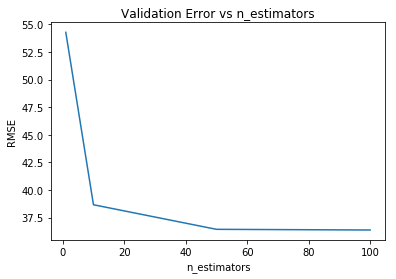

In [47]:
n_estimators = [1, 10, 50, 100]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = n), X_train_sel, y_train_sel).mean() 
            for n in n_estimators]

series = pd.Series(cv_rf_rmse, index = n_estimators)
plot_rmse_param(series, "n_estimators")

In [53]:
best_rmse_rf_sel, best_param_rf_sel = best_rmse_param(series)

model_rf_sel = RandomForestRegressor(n_estimators = best_param_rf_sel)
score_rf_sel, exec_time_sel = train_model(model_rf_sel, X_train_sel, y_train_sel, X_test_sel, y_test_sel, False)

In [ ]:
cs = [0.01, 1, 5, 10, 25, 50]
cv_svr_rmse = [rmse_cv(SVR(C = c), X_train_sel, y_train_sel).mean() 
            for c in cs]

series_svr = pd.Series(cv_svr_rmse, index = cs)
plot_rmse_param(series_svr, "C")

In [ ]:
best_rmse_svr_sel, best_param_svr_sel = best_rmse_param(series_svr)

model_svr_sel = SVR(C = best_param_svr_sel)
score_svr_sel, exec_time_sel_svr = train_model(model_svr_sel, False)

## Results

Execution just with Random Forest because is more efficient with good accuracy.

In [54]:
print("Data: %s rows" % rows_number)
print("Random Forest Model - All Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_param_rf, best_rmse_rf, score_rf, exec_time_all))
print("Random Forest Model - Less Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_param_rf_sel, best_rmse_rf_sel, score_rf_sel, exec_time_sel))

print("SVR Model - All Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_param_svr, best_rmse_svr, score_svr, exec_time_svr_all))
print("Random Forest Model - Less Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_param_svr_sel, best_rmse_svr_sel, score_svr_sel, exec_time_svr_sel))


Data: 50000 rows
Random Forest Model - All Variables: 
Estimators = 100 
RMSE = 36.38148260317509 
R2 = 0.7601908436771817 
Execution time = 69.8940000534 

Random Forest Model - Less Variables: 
Estimators = 100 
RMSE = 36.38148260317509 
R2 = 0.7516999435901272 
Execution time = 62.2489998341 

